### Лабораторная работа №2

# Методы снижения размерности

Седунов Илья, <br>
Альперович Вадим, <br>
МАГ-ИАД21.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

import warnings
warnings.simplefilter('ignore')
sns.set(style="darkgrid")

# 1. Data

Выполнить первичную обработку данных. Сделать первые выводы.

## 1.1 Data loading

|col 1 |col 2 |col 3 |col 4 |col 5 |col 6 |
| - | - | - | - | - | -|
| Возраст (лет)  | Количество иждивенцев     | Доход (руб./мес.)| Срок проживания в регионе (лет) | Оценка автомобиля заемщика (USD) | Размер кредита (тыс. руб.)|
| age  | dependents | income| residence | car_valuation | loan_amount |


In [3]:
%%time
columns = ['age', 'dependents', 'income', 'residence', 'car_valuation', 'loan_amount']
df = pd.read_excel('data/HW_2_v7.xls', 
                   header=None,
                   names=columns
                  )

Wall time: 47.9 ms


In [4]:
df.head()

,age,dependents,income,residence,car_valuation,loan_amount
0,54,3,16700,18,18000,177000
1,36,2,33800,6,34000,337000
2,37,1,12900,9,12000,126000
3,44,2,17700,13,18000,180000
4,54,4,20000,19,22000,211000


## 1.2 EDA

**Simple stats**

In [5]:
print(f'Rows count: {len(df)} Cols num: {df.shape[1]}')

Rows count: 50 Cols num: 6


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            50 non-null     int64
 1   dependents     50 non-null     int64
 2   income         50 non-null     int64
 3   residence      50 non-null     int64
 4   car_valuation  50 non-null     int64
 5   loan_amount    50 non-null     int64
dtypes: int64(6)
memory usage: 2.5 KB
None


In [7]:
np.around(df.describe(), 1)

,age,dependents,income,residence,car_valuation,loan_amount
count,50.0,50.0,50.0,50.0,50.0,50.0
mean,40.0,2.0,19992.0,10.0,20060.0,199960.0
std,8.0,1.0,10002.1,5.0,10096.3,100021.8
min,24.0,0.0,1500.0,0.0,0.0,4000.0
25%,35.0,1.2,12600.0,6.0,13000.0,126500.0
50%,40.0,2.0,17900.0,10.0,18500.0,183000.0
75%,46.0,2.8,29075.0,14.0,29750.0,293000.0
max,56.0,4.0,43300.0,19.0,44000.0,437000.0


**Charts & dists**

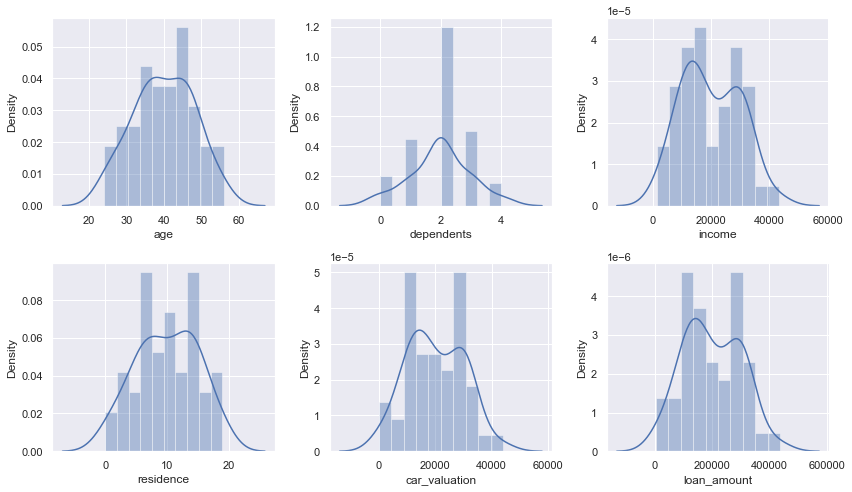

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3) 
axes = axes.flatten()        
fig.set_size_inches(12, 7)

for ax, col in zip(axes, df.columns):
    sns.distplot(df[col], ax = ax, bins=10)
fig.tight_layout()

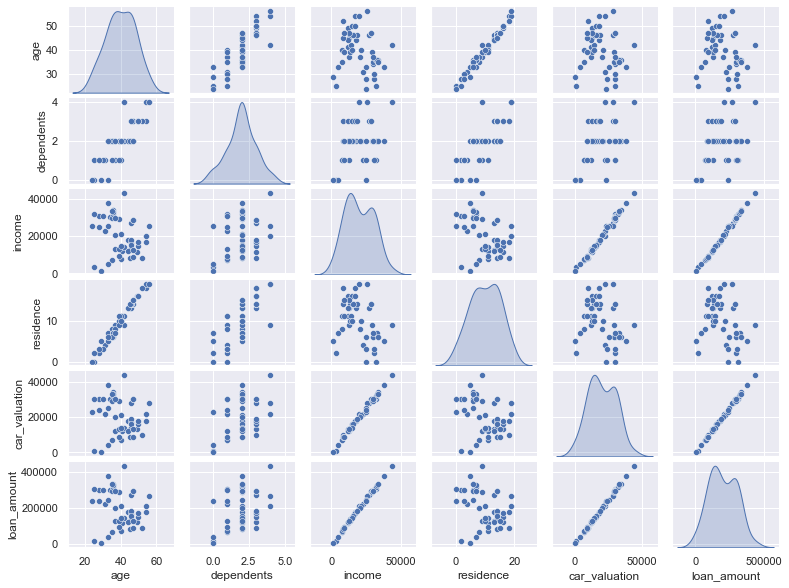

In [9]:
g = sns.pairplot(data=df, diag_kind="kde")
g.fig.set_figwidth(11)
g.fig.set_figheight(8)
pass

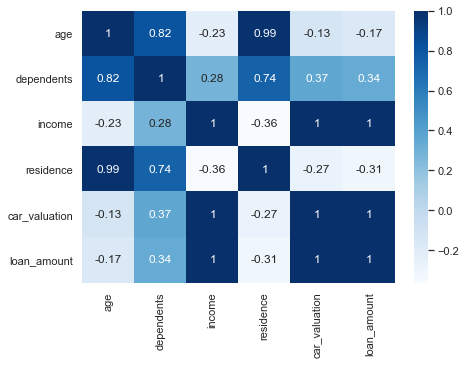

In [10]:
corr = df.corr(method='pearson')
plt.figure(figsize=(7, 5))
sns.heatmap(corr, cmap="Blues", annot=True)
pass

# 2. Dimensionality reduction via PCA

- Выполнить центрирование данных и такую нормировку, что евклидова норма каждого признака
равна 1 (полученная матрица обозначается через Z).
- Найти SVD разложение матрицы Z (матрицы U, S, V). Докажите, что при выбранной
нормировке, коэффициенты разложения столбцов матрицы Z по скрытым факторам являются
корреляциями этих столбцов и скрытых факторов.
- Исследуйте, сколько скрытых факторов (главные факторы) достаточно для хорошей
аппроксимации матрицы данных Z. Заменить значения исходных признаков линейными
комбинациями главных факторов (матрица Z k , k – число главных факторов). Оценить
погрешность аппроксимации в евклидовой матричной норме и норме Фробениуса.
- Сравнить матрицы корреляций признаков для матрицы Z и матрицы Z k . Оценить качество
аппроксимации по близости матриц корреляций (можно использовать относительную
погрешность в одной из матричных норм)
- Используя выделенные главные факторы, найти представления клиентов векторами меньшей
размерности (размерности k).
- Используя представление клиентов векторами меньшей размерности, построить карту
клиентов. Сделать выводы о клиентах банка.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html#sklearn.preprocessing.normalize
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [11]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, TruncatedSVD

**Data normalization**

*Выполнить центрирование данных и такую нормировку, что евклидова норма каждого признака равна 1*

In [12]:
Z = normalize(df, norm='l2', axis=0) 
df_normalized = pd.DataFrame(Z, columns=df.columns)
df_normalized.head()

,age,dependents,income,residence,car_valuation,loan_amount
0,0.187243,0.19245,0.105862,0.22752,0.113581,0.112182
1,0.124829,0.12830,0.214259,0.07584,0.214542,0.213590
2,0.128296,0.06415,0.081773,0.11376,0.075721,0.079859
3,0.152568,0.12830,0.112201,0.16432,0.113581,0.114084
4,0.187243,0.25660,0.126780,0.24016,0.138821,0.133732


In [13]:
# np.around(df_normalized.describe(), 1)

In [13]:
for col in df_normalized.columns:
    print(col, f'l2-norm: {round(np.linalg.norm(df_normalized[col], ord=2), 1)}')

age l2-norm: 1.0
dependents l2-norm: 1.0
income l2-norm: 1.0
residence l2-norm: 1.0
car_valuation l2-norm: 1.0
loan_amount l2-norm: 1.0


**SVD**

- *Найти SVD разложение матрицы Z (матрицы U, S, V).*
- *Докажите, что при выбранной нормировке, коэффициенты разложения столбцов матрицы Z по скрытым факторам являются корреляциями этих столбцов и скрытых факторов.*

In [14]:
from scipy.linalg import svd 

U, S, VT = np.linalg.svd(df_normalized,  full_matrices=False,  compute_uv=True)

In [15]:
from math import isclose

for i in range(Z.shape[1]):
    for j in range(U.shape[1]):
        corr_Zi_Uj = np.correlate(Z[:, i], U[:, j])[0]
        svd_coef = VT[j, i] * S[j]
        print(f'Feature Z_{i} and Component U_{j}')
        if isclose(corr_Zi_Uj, svd_coef):
            print(f'\tEqual: {corr_Zi_Uj:.2f} == {svd_coef:.2f}')
        else:
            print('\tNot equal')

Feature Z_0 and Component U_0
	Equal: -0.96 == -0.96
Feature Z_0 and Component U_1
	Equal: -0.22 == -0.22
Feature Z_0 and Component U_2
	Equal: 0.14 == 0.14
Feature Z_0 and Component U_3
	Equal: -0.04 == -0.04
Feature Z_0 and Component U_4
	Equal: -0.00 == -0.00
Feature Z_0 and Component U_5
	Equal: 0.00 == 0.00
Feature Z_1 and Component U_0
	Equal: -0.96 == -0.96
Feature Z_1 and Component U_1
	Equal: -0.20 == -0.20
Feature Z_1 and Component U_2
	Equal: -0.17 == -0.17
Feature Z_1 and Component U_3
	Equal: -0.03 == -0.03
Feature Z_1 and Component U_4
	Equal: 0.00 == 0.00
Feature Z_1 and Component U_5
	Equal: -0.00 == -0.00
Feature Z_2 and Component U_0
	Equal: -0.96 == -0.96
Feature Z_2 and Component U_1
	Equal: 0.29 == 0.29
Feature Z_2 and Component U_2
	Equal: 0.02 == 0.02
Feature Z_2 and Component U_3
	Equal: -0.00 == -0.00
Feature Z_2 and Component U_4
	Equal: 0.00 == 0.00
Feature Z_2 and Component U_5
	Equal: -0.00 == -0.00
Feature Z_3 and Component U_0
	Equal: -0.90 == -0.90
Featu

- *Исследуйте, сколько скрытых факторов (главные факторы) достаточно для хорошей аппроксимации матрицы данных Z. Заменить значения исходных признаков линейными комбинациями главных факторов (матрица Z k , k – число главных факторов).*
- *Оценить погрешность аппроксимации в евклидовой матричной норме и норме Фробениуса.*

In [16]:
print(f'Singular values: {np.around(S, 2)}')
sqr_singular_values = S ** 2
print(f'Sqr singular values: {np.around(sqr_singular_values, 2)}')
total_variance = np.sum(sqr_singular_values)
print(f'Total variance: {total_variance:.2f}')
explained_variances = S ** 2 / total_variance
print(f'Explained variances: {np.around(explained_variances, 2)}')

Singular values: [2.33 0.72 0.22 0.07 0.01 0.  ]
Sqr singular values: [5.43 0.52 0.05 0.   0.   0.  ]
Total variance: 6.00
Explained variances: [0.91 0.09 0.01 0.   0.   0.  ]


In [17]:
explained_var_2comp = np.sum(explained_variances)
print(f'Explained variance (via 2 components): {explained_var_2comp * 100:.1f}%')

Explained variance (via 2 components): 100.0%


In [18]:
K = 2
Z_K = U.dot(np.diag(S)[:,:K].dot(VT[:K, :]))
print('Original Z matrix:')
print(np.around(Z[:5], 2))

print('\nApproximated Z matrix by 2 components:')
print(np.around(Z_K[:5], 2))

Original Z matrix:
[[0.19 0.19 0.11 0.23 0.11 0.11]
 [0.12 0.13 0.21 0.08 0.21 0.21]
 [0.13 0.06 0.08 0.11 0.08 0.08]
 [0.15 0.13 0.11 0.16 0.11 0.11]
 [0.19 0.26 0.13 0.24 0.14 0.13]]

Approximated Z matrix by 2 components:
[[0.2  0.19 0.11 0.22 0.11 0.11]
 [0.12 0.13 0.22 0.08 0.21 0.21]
 [0.1  0.1  0.08 0.11 0.08 0.08]
 [0.15 0.15 0.11 0.15 0.11 0.11]
 [0.22 0.22 0.13 0.24 0.14 0.13]]


In [19]:
Z_errors = Z - Z_K
enorm_F = np.linalg.norm(Z_errors, ord='fro') ** 2
enorm_2 = np.linalg.norm(Z_errors, ord=2)

print(f'Approx error in Fro norm: {enorm_F:.3f} (sigma{K+1}^2+...sigmaN^2={np.sum(S[2:]**2):.3f})')
print(f'Approx error in Euclidian norm: {enorm_2:.3f} (sigma{K+1}={S[K]:.3f})')

Approx error in Fro norm: 0.054 (sigma3^2+...sigmaN^2=0.054)
Approx error in Euclidian norm: 0.223 (sigma3=0.223)


In [20]:
relative_enorm_F = enorm_F /  np.linalg.norm(Z, ord='fro') ** 2
print(f'Approx relative error in Frob norm: {(1 - explained_var_2comp) * 100:.3f}%')
print(f'Approx relative error in Frob norm: {(relative_enorm_F):.3f}%')

Approx relative error in Frob norm: 0.000%
Approx relative error in Frob norm: 0.009%


*Сравнить матрицы корреляций признаков для матрицы Z и матрицы Z k . Оценить качество аппроксимации по близости матриц корреляций*

In [21]:
df_approx_K = pd.DataFrame(Z_K, columns=df.columns)

In [22]:
Z_corr = df_normalized.corr()
np.around(df_normalized.corr(), 3)

,age,dependents,income,residence,car_valuation,loan_amount
age,1.000,0.819,-0.225,0.987,-0.132,-0.168
dependents,0.819,1.000,0.285,0.738,0.372,0.338
income,-0.225,0.285,1.000,-0.363,0.995,0.998
residence,0.987,0.738,-0.363,1.000,-0.272,-0.307
car_valuation,-0.132,0.372,0.995,-0.272,1.000,0.999
loan_amount,-0.168,0.338,0.998,-0.307,0.999,1.000


In [24]:
Z_K_corr = df_approx_K.corr()
np.around(df_approx_K.corr(), 3)

,age,dependents,income,residence,car_valuation,loan_amount
age,1.000,0.997,0.132,0.891,0.166,0.154
dependents,0.997,1.000,0.206,0.854,0.239,0.227
income,0.132,0.206,1.000,-0.333,0.999,1.000
residence,0.891,0.854,-0.333,1.000,-0.301,-0.312
car_valuation,0.166,0.239,0.999,-0.301,1.000,1.000
loan_amount,0.154,0.227,1.000,-0.312,1.000,1.000


In [25]:
corr_errors = Z_corr - Z_K_corr
ecorr_norm_F = np.linalg.norm(corr_errors, ord='fro') ** 2
ecorr_norm_2 = np.linalg.norm(corr_errors, ord=2)

print(f'Approx error in Fro norm: {ecorr_norm_F:.3f}')
print(f'Approx error in Euclidian norm: {ecorr_norm_2:.3f}')

Approx error in Fro norm: 0.826
Approx error in Euclidian norm: 0.679


**Visualization**

- *Используя выделенные главные факторы, найти представления клиентов векторами меньшей размерности (размерности k).*
- *Используя представление клиентов векторами меньшей размерности, построить карту клиентов. Сделать выводы о клиентах банка.*

In [26]:
comp_K = U[:, :K]
comp_K[:5]

array([[-0.16365566, -0.17058968],
       [-0.17106441,  0.17860289],
       [-0.09492935, -0.04908803],
       [-0.13711726, -0.07227935],
       [-0.18911208, -0.16968201]])

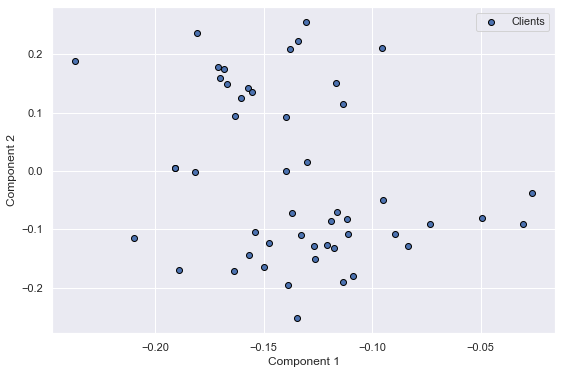

In [27]:
plt.figure(figsize=(9, 6))
plt.scatter(comp_K[:, 0], comp_K[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.show()

In [612]:
# def draw_vector(v0, v1, ax=None):
# #     ax = ax or plt.gca()
#     arrowprops=dict(arrowstyle='<-',
#                     linewidth=2,
#                     shrinkA=0, shrinkB=0,
#                     color='black')
#     plt.annotate('', v0, v1, arrowprops=arrowprops)

# plt.scatter(comp_K[:, 0], comp_K[:, 1], label='Clients', edgecolors='black')
# _mean = comp_K.mean(axis=0)
# for length, vector in zip(S[:2], VT[:2, :2].T):
#     print(vector, _mean)
#     print(length, _mean, _mean + vector)
#     v = vector * 0.5
#     draw_vector(_mean, _mean + v)
    
# plt.axis('equal')
# plt.show()

# 3. Latent factors analysis

- Выписать матрицу коэффициентов разложения признаков z j по главным факторам. Исследовать
структуру этой матрицы с целью выделения групп признаков тесно связанных с каждым из
главных факторов.
- На основе анализа структуры матрицы коэффициентов разложения, предложить интерпретацию
выделенным главным факторам.
- Дать интерпретацию построенной выше карте клиентов.
- Выполнить вращения в пространстве главных факторов с целью улучшения структуры матрицы
коэффициентов разложения признаков z j по главным факторам. В случае улучшения структуры,
найти новое представление клиентов векторами меньшей размерности (размерности k).
Построить улучшенную карту клиентов и дать ее интерпретацию.

*Выписать матрицу коэффициентов разложения признаков z j по главным факторам.*

In [171]:
K = 2
S_2 = np.diag(S[:K])
VT_2 = VT[:K,:]
A = S_2.dot(VT_2)
A.T

array([[-0.96371062, -0.22444133],
       [-0.96434137, -0.19952749],
       [-0.95634972,  0.29137546],
       [-0.89749176, -0.43836638],
       [-0.96327974,  0.26783823],
       [-0.96102749,  0.27624531]])

In [68]:
np.array([df_normalized.columns]).T

array([['age'],
       ['dependents'],
       ['income'],
       ['residence'],
       ['car_valuation'],
       ['loan_amount']], dtype=object)

*На основе анализа структуры матрицы коэффициентов разложения, предложить интерпретацию выделенным главным факторам*

**Комментарий:** Видно, что второй главный фактор имеет корреляцию со столбцами 'доход', 'стоимость автомобиля' и 'размер кредита'. Таким образом второй главный фактор можно интерпретировать, как 'уровень финансового состояния заёмщика'

С интерпретацией первого главного фактора неоднознаяная ситуация, по матрице нагрузок видно, что первый главный фактор не коррелирует не с одним из признаков.

*Дать интерпретацию построенной выше карте клиентов.*

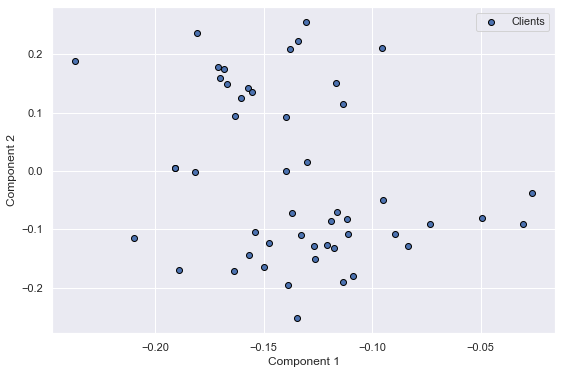

In [72]:
plt.figure(figsize=(9, 6))
plt.scatter(comp_K[:, 0], comp_K[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.show()

**Комментарий:** Можно предположить, что Component2 в на данном графике иллюстрирует разбиение клиентов на 2 группы (граница которой проходит по 0), группы более и менее финансово обеспеченных клиентов банка

*Выполнить вращения в пространстве главных факторов с целью улучшения структуры матрицы коэффициентов разложения признаков z j по главным факторам. В случае улучшения структуры, найти новое представление клиентов векторами меньшей размерности (размерности k). Построить улучшенную карту клиентов и дать ее интерпретацию.*

**Комментарий:** Для выполнения данного пункта воспользуемся библиотекой https://github.com/EducationalTestingService/factor_analyzer
Которая имеет функционал по вращению матрицы нагрузок и поддерживает методы:
```
            (a) varimax (orthogonal rotation)
            (b) promax (oblique rotation)
            (c) oblimin (oblique rotation)
            (d) oblimax (orthogonal rotation)
            (e) quartimin (oblique rotation)
            (f) quartimax (orthogonal rotation)
            (g) equamax (orthogonal rotation)
            (h) geomin_obl (oblique rotation)
            (i) geomin_ort (orthogonal rotation)
```

In [89]:
from factor_analyzer import Rotator
from factor_analyzer.rotator import ORTHOGONAL_ROTATIONS, OBLIQUE_ROTATIONS 

In [92]:
rotations = ORTHOGONAL_ROTATIONS + OBLIQUE_ROTATIONS
rotated_loadings = {}

In [191]:
for rotation_method in rotations:
    rotator = Rotator(method=rotation_method, max_iter=1)
    rotated_A = rotator.fit_transform(A)
    rotated_loadings[rotation_method] = {"loading" : np.around(rotated_A.T, 2), "rotation": rotator.rotation_}
    # print(f"method: {rotation_method}")
    # print(rotated_loadings[rotation_method]["loading"])

In [192]:
rotated_loadings["geomin_ort"]["loading"]

array([[-1.1 , -0.3 ],
       [-1.12, -0.25],
       [-0.91,  0.18],
       [ 0.29, -0.54],
       [-1.03,  0.13],
       [-0.99,  0.15]])

In [148]:
np.array([df_normalized.columns]).T

array([['age'],
       ['dependents'],
       ['income'],
       ['residence'],
       ['car_valuation'],
       ['loan_amount']], dtype=object)

**Комментарий:** Проведя эксперименты с разными видами поворотов матриццы нагрузок получили новый вариант матрицы, значения которой могут быть интерпретированы, как второй главный фактор - всё также отвечает за финансовое состояние заёмщика. А первая компонента отвечает за срок его проживания в регионе.

**Открытый вопрос:** почему значения после поворотов в матрице нагрузок < -1.0, если это корреляции. Возможно, ответ кроется в алгоритме 'gemin_ort', но это я пока не изучил

In [194]:
G = rotated_loadings["geomin_ort"]["rotation"]
comp_K_rotated = U.dot(G)[:, :K]
comp_K_rotated[:5]

array([[-0.13770238, -0.13773213],
       [-0.1641217 ,  0.18674905],
       [-0.07924588, -0.02788644],
       [-0.10289875, -0.0356782 ],
       [-0.18885281, -0.17184163]])

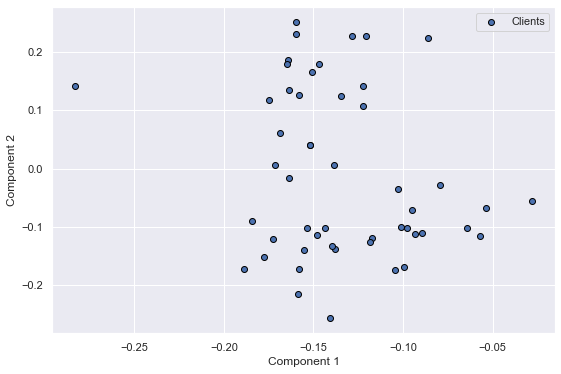

In [195]:
plt.figure(figsize=(9, 6))
plt.scatter(comp_K_rotated[:, 0], comp_K_rotated[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.show()

# 4. Dimensionality reduction with MDS

- Предложите способ вычисления расстояния между клиентами и вычислите матрицу
расстояний.
- Проверьте, можно ли клиентов банка поместить в евклидово пространство размерности 2 с
сохранением расстояний между клиентами.
- используйте любой из алгоритмов MDS для размещения объектов в евклидовом пространстве
размерности 2. Оцените погрешность такого размещения. Постройте карту клиентов.
- Сравните с картами клиентов из предыдущих пунктов и сделайте выводы.